In [1]:
import os
import random
import zipfile
from io import BytesIO

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt

import imageio
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import IPython.display as display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/My Drive/Colab Notebooks/AI/img_data_x16_balanced.zip'
unzip_path = '/content/'

if os.path.exists(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            zip_file.extractall(unzip_path)
        print(f"ZIP file extracted to {unzip_path}")
    except zipfile.BadZipFile:
        print("The file is not a valid ZIP archive.")
else:
    print(f"File not found at {zip_path}")

ZIP file extracted to /content/


In [9]:
def create_feature_extractor():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

    features = torch.nn.Sequential(*list(model.features.children())[:18])
    pooling_layer = torch.nn.AdaptiveAvgPool2d((1, 1))

    #input shape [1, 3, 224, 224]
    #After layer 0: [1, 320, 7, 7]
    #After pooling: torch.Size([1, 320, 1, 1])
    #After layer 2: torch.Size([1, 320])
    feature_extractor = torch.nn.Sequential(
        features,
        pooling_layer,
        torch.nn.Flatten(),
    )

    feature_extractor.eval()
    return feature_extractor


In [4]:
class_to_idx = {'behind': 0, 'in_front': 1, 'next_to': 2}
idx_to_class = {value:key for key, value in class_to_idx.items()}

In [ ]:
def save_features_and_labels(image_folder, cnn_model, save_folder, videos_per_folder=-1, augment=False):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    augmentation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cnn_model = cnn_model.to(device)

    folders = os.listdir(image_folder)  # Behind, front, etc.
    with torch.no_grad():
        for folder in folders:  # Folder name is the label (e.g., 'behind', 'front')
            folder_path = os.path.join(image_folder, folder)
            video_folders = os.listdir(folder_path)

            if videos_per_folder > 0:
              video_folders = random.sample(video_folders, videos_per_folder)

            for video_folder in video_folders:  # e.g., '10006', '10007'
                video_folder_path = os.path.join(folder_path, video_folder)
                image_files = sorted([f for f in os.listdir(video_folder_path) if f.endswith('.jpg')])

                video_features = []  # To store features for all frames in the video
                label = class_to_idx[folder]  # The label for the video (e.g., 1)
                state = torch.get_rng_state()

                for i, image_file in enumerate(image_files):  # Loop over frames in the video
                    img_path = os.path.join(video_folder_path, image_file)
                    img = Image.open(img_path).convert("RGB")             # [3, 224, 224]
                    img_tensor = preprocess(img).unsqueeze(0).to(device)  # mini-batch as expected by the model [1, 3, 224, 224]

                    # Extract features
                    if augment:
                      if i > 0:
                        torch.set_rng_state(state)

                      augmented_img = augmentation(img).unsqueeze(0).to(device)
                      extracted_features = cnn_model(img_tensor).squeeze().detach().cpu().numpy()
                      video_features.append(extracted_features)
                    else:
                      extracted_features = cnn_model(img_tensor).squeeze().detach().cpu().numpy()
                      video_features.append(extracted_features)


                # Save features in .npz format
                video_features = np.array(video_features)

                save_path = os.path.join(save_folder, folder, video_folder + '.npz')
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                np.savez(save_path, features=video_features, label=label)  # Save in the .npz format

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = create_feature_extractor().to(device)

In [ ]:
save_features_and_labels('img_data_x16/test/', model, 'extracted_features_x16_800_balanced_aug/test/', 100)
save_features_and_labels('img_data_x16/train/', model, 'extracted_features_x16_800_balanced_aug/train/', 800, augment=True)
save_features_and_labels('img_data_x16/validation/', model, 'extracted_features_x16_800_balanced_aug/validation/', 100)

In [6]:
import shutil

In [ ]:
shutil.copytree('extracted_features_x16_800_balanced_aug', '/content/drive/MyDrive/extracted_features_x16_800_balanced_aug', dirs_exist_ok=True)

In [7]:
#Load extracted features

#extracted_features_x16 16 frame for each video, 1600 train video / category (800 augmented, 800 not augmented)
#extracted_features_x16_800 16 frame for each video, 800 augmented train video / category
#extracted_features_x16_800_balanced 16 frame for each video, 800 not augmented train video / category + 100 test and 100 validation / category
#extracted_features_x16_800_balanced_aug 16 frame for each video, 800 augmented train video / category + 100 test and 100 validation / category
shutil.copytree('/content/drive/MyDrive/extracted_features_x16_800_balanced', 'extracted_features_x16_800_balanced', dirs_exist_ok=True)

'extracted_features_x16_800_balanced'

In [9]:
file_path = 'extracted_features_x16_800_balanced/train/behind/100106.npz'  # Path to one of the saved files
loaded_data = np.load(file_path)

features = loaded_data['features']  # The extracted features for each frame
label = loaded_data['label']  # The label for the video

print("Features Shape:", features.shape)  # (num_frames, feature_size)
print("Label:", label)  # (e.g., 0 (for 'behind'))

#print("First frame features:", features[0])

Features Shape: (16, 320)
Label: 0


In [ ]:
folder_path = '/content/extracted_features_x16_800_balanced_aug/train'
items = os.listdir(folder_path)

for item in items:
  path = os.path.join(folder_path, item)
  items = os.listdir(path)
  print(item, len(items))

In [12]:
class VideoDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = [os.path.join(root, file)
                      for root, _, files in os.walk(data_dir)
                      for file in files if file.endswith('.npz')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        data = np.load(file_path)
        features, label = data['features'], data['label']
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [13]:
train_dataset = VideoDataset('extracted_features_x16_800_balanced/train')
val_dataset = VideoDataset('extracted_features_x16_800_balanced/validation')
test_dataset = VideoDataset('extracted_features_x16_800_balanced/test')

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [14]:
class VideoClassificationRNN(nn.Module):
    def __init__(self, input_size=320, hidden_size=16, num_layers=2, num_classes=3):
        super(VideoClassificationRNN, self).__init__()

        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.35, bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: (batch_size, frames, feature_size) = (32, 16, 320)

        _, hn = self.rnn(x) # hn Contains the final hidden states from all GRU layers (shape: (num_layers * 2, batch_size, hidden_size))

        # Concatenate the last hidden states from both directions
        hn = torch.cat((hn[-2], hn[-1]), dim=1)

        x = self.fc(hn)
        return x

Training 1/100 done, training loss: 1.0655800104141235, validation loss: 1.008562445640564
Training 2/100 done, training loss: 0.8916388154029846, validation loss: 0.876471221446991
Training 3/100 done, training loss: 0.786279022693634, validation loss: 0.845280647277832
Training 4/100 done, training loss: 0.7193678021430969, validation loss: 0.788345217704773
Training 5/100 done, training loss: 0.6841050982475281, validation loss: 0.7970485687255859
Training 6/100 done, training loss: 0.663543164730072, validation loss: 0.8054752349853516
Training 7/100 done, training loss: 0.6540746688842773, validation loss: 0.8261033296585083
Training 8/100 done, training loss: 0.6377210021018982, validation loss: 0.7906296253204346
Training 9/100 done, training loss: 0.6298115849494934, validation loss: 0.7776306867599487
Training 10/100 done, training loss: 0.6221166253089905, validation loss: 0.7567098140716553
Training 11/100 done, training loss: 0.605038583278656, validation loss: 0.7893041968

<ipython-input-16-460d953869a8>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


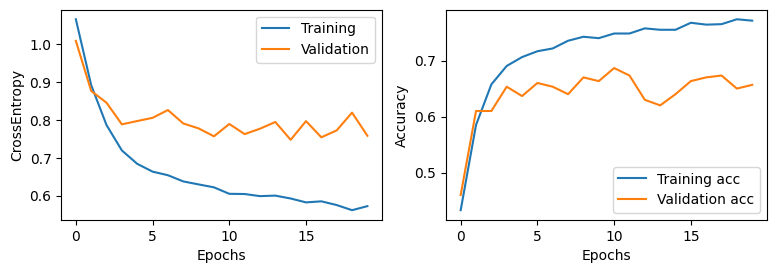

Test accuracy:  0.5566666722297668


In [16]:
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []
  train_acc = []
  val_acc = []

  best_loss = np.inf
  no_improvement_count = 0

  for epoch in range(n_epochs):
    model.train()
    train_epoch_losses = []
    train_epoch_acc = []

    for x, y in dataloader_train:
      optimizer.zero_grad()
      y_hat = model(x)
      prediction = torch.argmax(y_hat, dim=1)
      train_epoch_acc.append((prediction == y).to(torch.float32))
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)

    train_epoch_acc = torch.cat(train_epoch_acc).mean()
    train_acc.append(train_epoch_acc)

    model.eval()
    val_epoch_losses = []
    val_epoch_acc = []

    for x, y in dataloader_val:
      with torch.no_grad():
        y_hat = model(x)

      prediction = torch.argmax(y_hat, dim=1)
      val_epoch_acc.append((prediction == y).to(torch.float32))
      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)

    val_epoch_acc = torch.cat(val_epoch_acc).mean()
    val_acc.append(val_epoch_acc)

    if avg_epoch_loss + delta < best_loss:
      best_loss = avg_epoch_loss
      no_improvement_count = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      no_improvement_count += 1

    print(f'Training {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

    if no_improvement_count >= patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', best_loss.item())
      return train_losses, val_losses, train_acc, val_acc

  return train_losses, val_losses, train_acc, val_acc


model = VideoClassificationRNN(input_size=320, hidden_size=16, num_layers=2, num_classes=3).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0025
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

train_losses, val_losses, train_acc, val_acc = train(model, dataloader_train, dataloader_val, optimizer, loss_fn, n_epochs=100, patience=10)


model.load_state_dict(torch.load('best_model.pth'))


plt.figure(figsize=(24, 6))

plt.subplot(2, 5, 1)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()

plt.subplot(2, 5, 2)
plt.plot(train_acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



model.eval()
test_acc = []
input_prediction_label_triplets = []
for x, y in dataloader_test:
    with torch.no_grad():
      y_hat = model(x)
    prediction = torch.argmax(y_hat, dim=1)
    input_prediction_label_triplets.append((x, prediction, y))
    test_acc.append((prediction == y).to(torch.float32))

test_acc = torch.cat(test_acc).mean()
print('Test accuracy: ', test_acc.item())

Avg Test Loss: 0.974688071012497, Test Accuracy: 0.5567


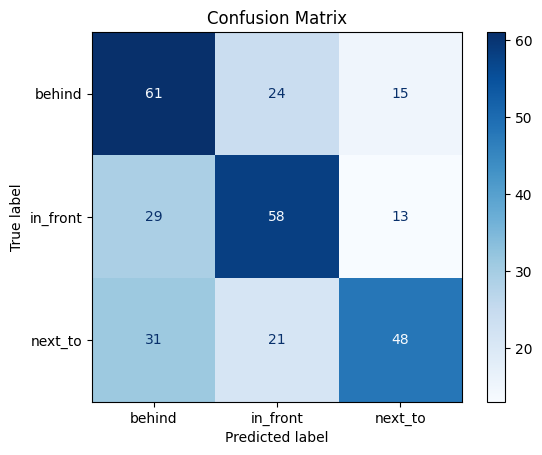

In [17]:
all_labels = []
all_predictions = []

model.eval()
criterion = nn.CrossEntropyLoss()
test_losses = []
correct = 0
total = 0

with torch.no_grad():
    for features, labels in dataloader_test:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Avg Test Loss: {np.mean(test_losses)}, Test Accuracy: {test_accuracy:.4f}")

class_names = [cls for cls in class_to_idx.keys()]

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Replace class_names with your label list
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [18]:
def to_gif(image_folder, duration=150):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

    images = [Image.open(img) for img in image_files]

    gif_buffer = BytesIO()
    imageio.mimsave(gif_buffer, images, format="GIF", duration=duration, loop=5)
    gif_buffer.seek(0)

    return display.Image(data=gif_buffer.getvalue(), format='gif')

Prediction: in_front; Label: in_front


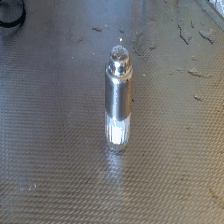

In [19]:
file_path = 'extracted_features_x16_800_balanced/test/in_front/207006.npz'  # behind/178619.npz ; in_front/207006.npz ; next_to/10221.npz
img_path = 'img_data_x16/test/in_front/207006'
loaded_data = np.load(file_path)

features = torch.tensor(loaded_data['features'])
features = features = features.unsqueeze(0)
label = loaded_data['label']

prediction = model(features)
predicted_class = torch.argmax(prediction).item()

print(f"Prediction: {idx_to_class[predicted_class]}; Label: {idx_to_class[label.item()]}")
gif_display = to_gif(img_path)
display.display(gif_display)

In [20]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(8, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x


Training 1/100 done, training loss: 1.102644443511963, validation loss: 1.091286301612854
Training 2/100 done, training loss: 1.0681673288345337, validation loss: 1.051582932472229
Training 3/100 done, training loss: 1.0079150199890137, validation loss: 1.0375683307647705
Training 4/100 done, training loss: 0.9610761404037476, validation loss: 1.0018341541290283
Training 5/100 done, training loss: 0.9307145476341248, validation loss: 1.0260063409805298
Training 6/100 done, training loss: 0.9113209843635559, validation loss: 1.000720500946045
Training 7/100 done, training loss: 0.8868094682693481, validation loss: 1.0044580698013306
Training 8/100 done, training loss: 0.8626800775527954, validation loss: 1.026428461074829
Training 9/100 done, training loss: 0.8428148627281189, validation loss: 1.0115059614181519
Training 10/100 done, training loss: 0.8284663558006287, validation loss: 1.023474931716919
Training 11/100 done, training loss: 0.8111071586608887, validation loss: 1.005684852

<ipython-input-24-1effa526b4f2>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load('best_model.pth'))


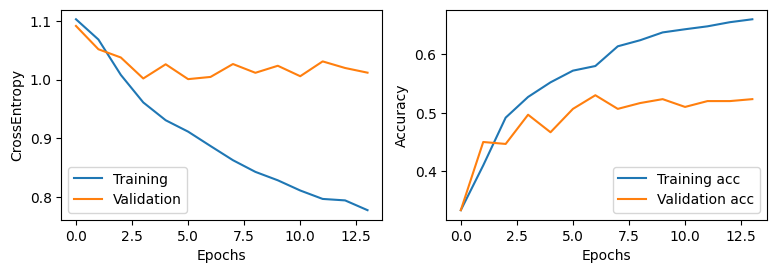

Test Accuracy: 0.4266666769981384


In [24]:
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    best_loss = np.inf
    no_improvement_count = 0

    for epoch in range(n_epochs):
        model.train()
        train_epoch_losses = []
        train_epoch_acc = []

        for x, y in train_dataloader:
            optimizer.zero_grad()
            batch_size, frames, features = x.shape  # x.shape = [batch, 16, 320]
            frame_predictions = []

            # Process each frame independently
            for t in range(frames):
                frame_input = x[:, t, :]  # shape = [batch_size, 320]
                frame_pred = model(frame_input)  # shape = [batch_size, 3]
                frame_predictions.append(frame_pred)

            frame_predictions = torch.stack(frame_predictions, dim=1)  # [batch_size, 16, 3]
            video_predictions = torch.mean(frame_predictions, dim=1)  # Average across frames -> [batch_size, 3]
            prediction = torch.argmax(video_predictions, dim=-1)  # Final class prediction -> [batch_size]

            train_epoch_acc.append((prediction == y).to(torch.float32))
            loss = loss_fn(video_predictions, y)
            train_epoch_losses.append(loss)

            loss.backward()
            optimizer.step()

        train_epoch_losses = torch.tensor(train_epoch_losses)
        avg_epoch_loss = train_epoch_losses.mean()
        train_losses.append(avg_epoch_loss)

        train_epoch_acc = torch.cat(train_epoch_acc).mean()
        train_acc.append(train_epoch_acc)

        model.eval()
        val_epoch_losses = []
        val_epoch_acc = []

        for x, y in val_dataloader:
            with torch.no_grad():
                batch_size, frames, features = x.shape
                frame_predictions = []

                for t in range(frames):
                    frame_input = x[:, t, :]
                    frame_pred = model(frame_input)
                    frame_predictions.append(frame_pred)

                frame_predictions = torch.stack(frame_predictions, dim=1)
                video_predictions = torch.mean(frame_predictions, dim=1)
                prediction = torch.argmax(video_predictions, dim=1)

                val_epoch_acc.append((prediction == y).to(torch.float32))
                loss = loss_fn(video_predictions, y)
                val_epoch_losses.append(loss)

        val_epoch_losses = torch.tensor(val_epoch_losses)
        avg_epoch_loss = val_epoch_losses.mean()
        val_losses.append(avg_epoch_loss)

        val_epoch_acc = torch.cat(val_epoch_acc).mean()
        val_acc.append(val_epoch_acc)

        if avg_epoch_loss + delta < best_loss:
            best_loss = avg_epoch_loss
            no_improvement_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement_count += 1

        print(f'Training {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

        if no_improvement_count >= patience:
            print('Stopped by early stopping.')
            print('Best validation loss: ', best_loss.item())
            return train_losses, val_losses, train_acc, val_acc

    return train_losses, val_losses, train_acc, val_acc



mlp_model = MLPModel(320, 3)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=0.001)


train_losses, val_losses, train_acc, val_acc = train(mlp_model, dataloader_train, dataloader_val, optimizer, loss_fn, n_epochs=100, patience=10)


mlp_model.load_state_dict(torch.load('best_model.pth'))


plt.figure(figsize=(24, 6))

plt.subplot(2, 5, 1)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()

plt.subplot(2, 5, 2)
plt.plot(train_acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


mlp_model.eval()
test_acc = []
for x, y in dataloader_test:
    with torch.no_grad():
        batch_size, frames, features = x.shape
        frame_predictions = []

        for t in range(frames):
            frame_input = x[:, t, :]
            frame_pred = mlp_model(frame_input)
            frame_predictions.append(frame_pred)

        frame_predictions = torch.stack(frame_predictions, dim=1)
        video_predictions = torch.mean(frame_predictions, dim=1)
        prediction = torch.argmax(video_predictions, dim=1)
        test_acc.append((prediction == y).to(torch.float32))

test_acc = torch.cat(test_acc).mean()
print('Test Accuracy:', test_acc.item())


Avg Test Loss: 1.0695269227027893, Test Accuracy: 0.4267


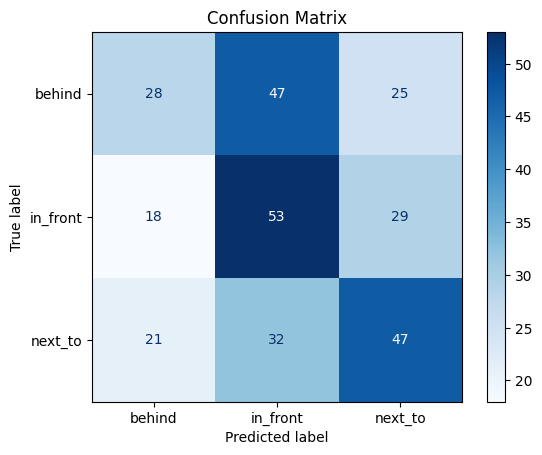

In [25]:
all_labels = []
all_predictions = []

mlp_model.eval()
criterion = nn.CrossEntropyLoss()
test_losses = []
correct = 0
total = 0

with torch.no_grad():
    for features, labels in dataloader_test:
        features, labels = features.to(device), labels.to(device)

        outputs = mlp_model(features)
        video_predictions = torch.mean(outputs, dim=1)
        loss = criterion(video_predictions, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(video_predictions, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Avg Test Loss: {np.mean(test_losses)}, Test Accuracy: {test_accuracy:.4f}")

class_names = [cls for cls in class_to_idx.keys()]

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Replace class_names with your label list
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Prediction: in_front; Label: next_to


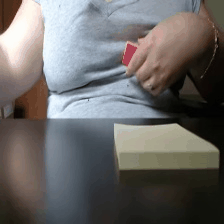

In [26]:
file_path = 'extracted_features_x16_800_balanced/test/next_to/10221.npz'  # behind/178619.npz ; in_front/207006.npz ; next_to/10221.npz
img_path = 'img_data_x16/test/next_to/10221'
loaded_data = np.load(file_path)

# Check the contents
features = torch.tensor(loaded_data['features'])  # The extracted features for each frame
label = loaded_data['label']  # The label for the video

outputs = mlp_model(features)
video_predictions = torch.mean(outputs, dim=0)
prediction = torch.argmax(video_predictions)

print(f"Prediction: {idx_to_class[prediction.item()]}; Label: {idx_to_class[label.item()]}")
gif_display = to_gif(img_path)
display.display(gif_display)